### Candidate Numbers : 44026, ???, ??? ###

<img src="/Users/tomasmock/LSE/Managing%20and%20Visualising%20Data/2024-project-macro-financial-market/financial%20market%20imagae.webp" alt="Financial Market Image" width="1500" height="500"/>


# Impact of Macroeconomic Indicators on Business Sectors in the U.S. Stock Market Since 2000 #

### 1. Introduction ###

The U.S. stock market, a cornerstone of the global financial system, reflects the dynamic interplay between macroeconomic conditions and business sector performance. Since 2000, the market has experienced a series of significant economic shifts, from the dot-com bubble and the 2008 financial crisis to periods of recovery and sustained growth. Understanding how macroeconomic indicators influence different business sectors is crucial for policymakers, investors, and industry stakeholders seeking to navigate these fluctuations effectively. This project explores the impact of macroeconomic indicators on U.S. business sectors, focusing on how economic factors have shaped sector performance over the past two decades. The objectives are threefold: first, to analyse the performance of business sectors during key economic phases—such as expansions, recessions, and recoveries—highlighting sector resilience and adaptability under varying macroeconomic conditions; second, to examine the relationship between macroeconomic indicators like the unemployment rate, CPI, Federal Funds Rate, Real GDP, and consumer sentiment, identifying the most influential factors and their impact on specific sectors; and third, to develop a simple, data-driven model that predicts how changes in these indicators could influence sector performance. By integrating historical data with statistical techniques, this study provides a framework for evaluating the relationship between macroeconomic conditions and stock market performance, offering practical insights for informed decision-making.

### 2.0 Acquiring and pre-processing data ###

The data was gathered and pre-processed through a series of steps to ensure comprehensive coverage of over two decades of economic and financial information, making it ready for analysis. First, a date range from January 1, 2000, to December 31, 2024, was set to filter the data. A list of key economic indicators, such as the Unemployment Rate, CPI, Fed Funds Rate, Real GDP, Consumer Sentiment, Industrial Production, Retail Sales, Home Price Index, Crude Oil, and EUR/USD Exchange Rate, was mapped to their specific FRED series IDs. Using a custom function, each of these indicators was downloaded from the FRED website in CSV format and limited to the defined date range.

Since the data sources had different frequencies—some were daily, others monthly or quarterly—daily data such as Crude Oil prices and EUR/USD exchange rates were resampled to monthly intervals by taking the last value of each month. For quarterly data, such as Real GDP, the values were forward-filled to create a consistent monthly dataset.

All the individual datasets were then merged into a single comprehensive DataFrame based on their dates. To make the column names more intuitive, they were renamed from their FRED codes to descriptive names, such as "Unemployment_Rate" and "CPI." The combined data was saved as a CSV file for easy access. Next, any missing values were addressed by first forward-filling and then backward-filling to ensure no gaps remained, particularly in the Real GDP data, where some months were intentionally set to NaN and later interpolated.

In addition to economic indicators, sector-specific financial data was pulled from Yahoo Finance using its API. This included both sector ETFs and representative stocks for sectors like Communication Services and Real Estate, as these two sectors lacked indices dating back to 2000. Companies like AT&T, Disney, Netflix, Verizon, and Comcast were chosen to represent the Communication Services sector, while American Tower Corporation, Prologis, Simon Property Group, Equinix, and Public Storage were selected for the Real Estate sector. Each stock’s adjusted closing prices were downloaded and used to build sector indices by calculating daily returns, averaging them for equal weighting, and then computing cumulative returns. The daily returns were then resampled by taking the last available value of each month to create a dataset with monthly granularity to allign with macroeconomic data frequencies. Lastly, these sector indices were normalised to start at 100 for easier comparison and rounded to two decimal places for clarity.

Finally, the economic and business sector datasets were combined into a single comprehensive DataFrame. The cleaned and finalised dataset was saved as a CSV file, ready for further analysis.



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.colors as mcolors  

### 2.1 Economic Data ###

In [32]:
# Define start and end date for filtering after download
start_date = "2000-01-01"
end_date = "2024-12-31"

# A dictionary of indicator names mapped to their FRED series IDs

fred_series = {
    "Unemployment_Rate": "UNRATE",                  # Monthly, %
    "CPI": "CPIAUCSL",                              # Monthly CPI index
    "Fed_Funds_Rate": "FEDFUNDS",                   # Monthly avg % rate
    "Real_GDP": "GDPC1",                            # Quarterly real GDP
    "Consumer_Sentiment": "UMCSENT",                # Monthly consumer sentiment as proxy for confidence
    "Industrial_Production": "INDPRO",              # Monthly IP index
    "Retail_Sales": "RSAFS",                        # Monthly retail sales
    "Home_Price_Index": "CSUSHPINSA",               # Monthly Case-Shiller home price index
    "Crude_Oil_WTI": "DCOILWTICO",                  # Daily WTI oil price
    "EUR_USD_Exchange_Rate": "DEXUSEU"              # Daily EUR to USD exchange rate
}

def download_fred_data(series_id):
    """
    Downloads data from FRED in CSV format using a direct URL pattern.
    Returns a DataFrame with a datetime index and a single column of values.
    """
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = pd.read_csv(url, parse_dates=["observation_date"])
    df.set_index("observation_date", inplace=True)
    df.columns = [series_id]
    return df

# Download data for each series and store in a dictionary of DataFrames
data_frames = {}
for name, sid in fred_series.items():
    print(f"Downloading {name} ({sid})...")
    df = download_fred_data(sid)
    # Filter by date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    data_frames[name] = df

# Alligning frequencies
for name in ["Crude_Oil_WTI", "EUR_USD_Exchange_Rate"]:
    if name in data_frames:
        data_frames[name] = data_frames[name].resample('M').last()  # using last available value in each month

# For quarterly GDP data I am using forward fill to get a monthly frequency (the same value for all months in the quarter)
if "Real_GDP" in data_frames:
    # Forward fill monthly so each month in the quarter carries the latest GDP value
    data_frames["Real_GDP"] = data_frames["Real_GDP"].resample('M').ffill()
    

# Merge all dataframes on the index (Date)
combined_df = None
for name, df in data_frames.items():
    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.join(df, how='outer')

# Renaming columns to be more descriptive
column_map = {fred_series[k]: k for k in fred_series.keys()}
combined_df.rename(columns=column_map, inplace=True)

# Exporting to CSV
combined_df.to_csv("/tmp/us_macro_data_2000_2024.csv")


print("Data successfully saved to us_macro_data_2000_2024.csv")

Data successfully saved to us_macro_data_2000_2024.csv


In [33]:
combined_df.head()

,Unemployment_Rate,CPI,Fed_Funds_Rate,Real_GDP,Consumer_Sentiment,Industrial_Production,Retail_Sales,Home_Price_Index,Crude_Oil_WTI,EUR_USD_Exchange_Rate
observation_date,,,,,,,,,,
2000-01-01,4.0,169.3,5.45,NaN,112.0,91.4092,268044.0,100.000,NaN,NaN
2000-01-31,NaN,NaN,NaN,13878.147,NaN,NaN,NaN,NaN,27.65,0.9757
2000-02-01,4.1,170.0,5.73,NaN,111.3,91.7245,272020.0,100.571,NaN,NaN
2000-02-29,NaN,NaN,NaN,13878.147,NaN,NaN,NaN,NaN,30.57,0.9643
2000-03-01,4.0,171.0,5.85,NaN,107.1,92.0830,275192.0,101.466,NaN,NaN


In [34]:
# Converting index to monthly periods
combined_df.index = combined_df.index.to_period('M')


# Grouping by the monthly period and combining the data
def fill_month_data(group):
    # Forward fill then backward fill within the monthly group to eliminate NaNs
    return group.ffill().bfill()

filled = combined_df.groupby(level=0).apply(fill_month_data)

monthly_df = filled.groupby(level=0).last()

# Converting the PeriodIndex back to a Timestamp 
monthly_df.index = monthly_df.index.to_timestamp('M')

# Saving the result
monthly_df.to_csv("us_macro_data_monthly_aligned.csv")

In [35]:
# Calculating the number of missing values per column
missing_values = monthly_df.isnull().sum()

# Filtering columns that have missing values
missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
Unemployment_Rate        1
CPI                      1
Fed_Funds_Rate           1
Real_GDP                 5
Consumer_Sentiment       2
Industrial_Production    2
Retail_Sales             2
Home_Price_Index         3
dtype: int64


In [36]:
# modifying the original DataFrame in place
monthly_df.fillna(method='ffill', inplace=True)

In [37]:
# Define months to set as NaN
months_to_nan = [2, 3, 5, 6, 8, 9, 11, 12]

# Replace specified months with NaN
monthly_df.loc[monthly_df.index.month.isin(months_to_nan), 'Real_GDP'] = np.nan

# Interpolate missing values
monthly_df['Real_GDP'] = monthly_df['Real_GDP'].interpolate(method='time')


monthly_df.head()

,Unemployment_Rate,CPI,Fed_Funds_Rate,Real_GDP,Consumer_Sentiment,Industrial_Production,Retail_Sales,Home_Price_Index,Crude_Oil_WTI,EUR_USD_Exchange_Rate
observation_date,,,,,,,,,,
2000-01-31,4.0,169.3,5.45,13878.147000,112.0,91.4092,268044.0,100.000,27.65,0.9757
2000-02-29,4.1,170.0,5.73,13959.592211,111.3,91.7245,272020.0,100.571,30.57,0.9643
2000-03-31,4.0,171.0,5.85,14046.654333,107.1,92.0830,275192.0,101.466,26.86,0.9574
2000-04-30,3.8,170.9,6.02,14130.908000,109.2,92.6659,271046.0,102.541,25.71,0.9089
2000-05-31,4.0,171.2,6.27,14135.761522,110.7,92.9347,271394.0,103.702,29.03,0.9328


In [38]:
# columns to round
columns_to_round = ['Real_GDP', 'Industrial_Production', 'Home_Price_Index', 'EUR_USD_Exchange_Rate']

# Rounding the specified columns to 2 decimal places
monthly_df[columns_to_round] = monthly_df[columns_to_round].round(2)

In [39]:
# Saving data
monthly_df.reset_index().to_csv('economic_indicators.csv', index=False)

### 2.2 Sector-specific Financial Data ###

In [40]:
# Defining the list of sector ETFs based on GICS 
sector_etfs = {
    
    'Materials': 'XLB',                       
    'Energy': 'XLE',                          
    'Financials': 'XLF',                      
    'Industrials': 'XLI',                     
    'Technology': 'XLK',                      
    'Consumer Staples': 'XLP',                
    'Utilities': 'XLU',                       
    'Health Care': 'XLV',                     
    'Consumer Discretionary': 'XLY'           
}

# the date range
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# empty DataFrame to store adjusted close prices
sector_data = pd.DataFrame()

# Function to download data and handle exceptions
def download_sector_data(sector, ticker, start, end):
    print(f"Downloading data for {sector} ({ticker})...")
    try:
        data = yf.download(ticker, start=start, end=end, progress=False)
        if data.empty:
            print(f"Warning: No data found for {ticker}. Skipping...")
            return None
        return data['Adj Close']
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

# Downloading data for each sector ETF
for sector, ticker in sector_etfs.items():
    adj_close = download_sector_data(sector, ticker, start_date, end_date)
    if adj_close is not None:
        sector_data[sector] = adj_close


# the first few rows of the collected data
sector_data.head()

,Materials,Energy,Financials,Industrials,Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary
Date,,,,,,,,,
2000-01-03,14.887234,13.962523,11.351280,18.467203,41.629463,12.635743,11.514973,20.980354,22.582930
2000-01-04,14.743911,13.699697,10.855048,17.957001,39.517490,12.279931,11.167623,20.504267,21.903555
2000-01-05,15.353011,14.061080,10.769757,17.876970,38.930832,12.496892,11.449439,20.320320,21.634174
2000-01-06,15.747142,14.603150,11.242732,18.117067,37.640175,12.731205,11.429770,20.385250,21.880133
2000-01-07,15.738176,14.759211,11.428814,18.807333,38.297234,13.538295,11.528080,20.634102,22.910894


In [41]:
# Defining the list of representative stocks for each sector
sector_stocks = {
    'Communication Services': ['T', 'VZ', 'DIS', 'CMCSA', 'NFLX'],
    'Real Estate': ['AMT', 'PLD', 'SPG', 'EQIX', 'PSA']
}

# the date range
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to download adjusted close prices
def get_adjusted_close(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, progress=False)['Adj Close']
    return data

# DataFrame to store sector indices
sector_indices = pd.DataFrame()

# Iterate over each sector
for sector, tickers in sector_stocks.items():
    print(f"Constructing index for {sector} sector...")
    
    # Download data for the sector's stocks
    adj_close = get_adjusted_close(tickers, start_date, end_date)
    
    # Drop rows with all NaNs
    adj_close.dropna(how='all', inplace=True)
    
    # Handle missing data by forward filling, then backward filling
    adj_close.fillna(method='ffill', inplace=True)
    adj_close.fillna(method='bfill', inplace=True)
    
    # Calculate daily returns
    daily_returns = adj_close.pct_change().dropna()
    
    # Calculate mean daily return for equal weighting
    mean_daily_return = daily_returns.mean(axis=1)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + mean_daily_return).cumprod()
    
    # Add to sector_indices DataFrame
    sector_indices[sector] = cumulative_returns

# Display sample data
print("\nSample of constructed sector indices:")
print(sector_indices.head())

Constructing index for Communication Services sector...
Constructing index for Real Estate sector...

Sample of constructed sector indices:
            Communication Services  Real Estate
Date                                           
2000-01-04                0.978575     0.992503
2000-01-05                0.991185     0.999247
2000-01-06                0.986085     1.013656
2000-01-07                0.977003     1.040101
2000-01-10                1.033626     1.066211


In [42]:
# Using pd.concat for merging on the index
combined_sector_data = pd.concat([sector_indices, sector_data], axis=1, join='outer')

In [43]:
# Removing the first row
combined_sector_data = combined_sector_data.iloc[1:]

# Resampling to monthly frequency, taking the last available value in each month
monthly_sector_data = combined_sector_data.resample('M').last()

# Normalising all variables to start at 100
columns_to_normalize = monthly_sector_data.columns.tolist()

monthly_sector_data[columns_to_normalize] = monthly_sector_data[columns_to_normalize].apply(
    lambda x: (x / x.iloc[0]) * 100
)

# Rounding all variables to 2 decimal places
monthly_sector_data = monthly_sector_data.round(2)

monthly_sector_data.head()

,Communication Services,Real Estate,Materials,Energy,Financials,Industrials,Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary
Date,,,,,,,,,,,
2000-01-31,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2000-02-29,90.90,105.31,89.95,95.77,89.30,94.48,110.51,88.30,87.85,93.46,94.43
2000-03-31,102.26,106.37,99.03,107.68,105.60,107.64,119.78,91.62,97.44,101.87,107.79
2000-04-30,103.52,109.69,95.74,106.08,106.62,109.19,108.78,96.48,103.82,100.67,105.55
2000-05-31,100.01,105.05,92.72,118.53,109.00,108.73,97.47,103.36,103.59,97.98,99.85


In [44]:
# Saving the modified DataFrame
monthly_sector_data.to_csv('business_sector_data.csv')

In [45]:
sector_data = pd.read_csv('business_sector_data.csv')
econ_data = pd.read_csv('economic_indicators.csv')

In [46]:
# Using pd.concat for merging on the index
combined_data = pd.concat([econ_data, sector_data], axis=1, join='outer')

In [49]:
# Assuming combined_data is your DataFrame
combined_data = combined_data.drop('Date', axis=1)

In [52]:
# Saving the combined DataFrame
combined_data.to_csv('cleaned_combined_data.csv')

# 3.0 Analysis of sector performance #

In [2]:
# Loading dataset
data = pd.read_csv('cleaned_combined_data.csv')

# 'DATE' column to datetime
data['observation_date'] = pd.to_datetime(data['observation_date'])

# Sorting the data by date in ascending order
data.sort_values('observation_date', inplace=True)

# 'DATE' as the index
data.set_index('observation_date', inplace=True)


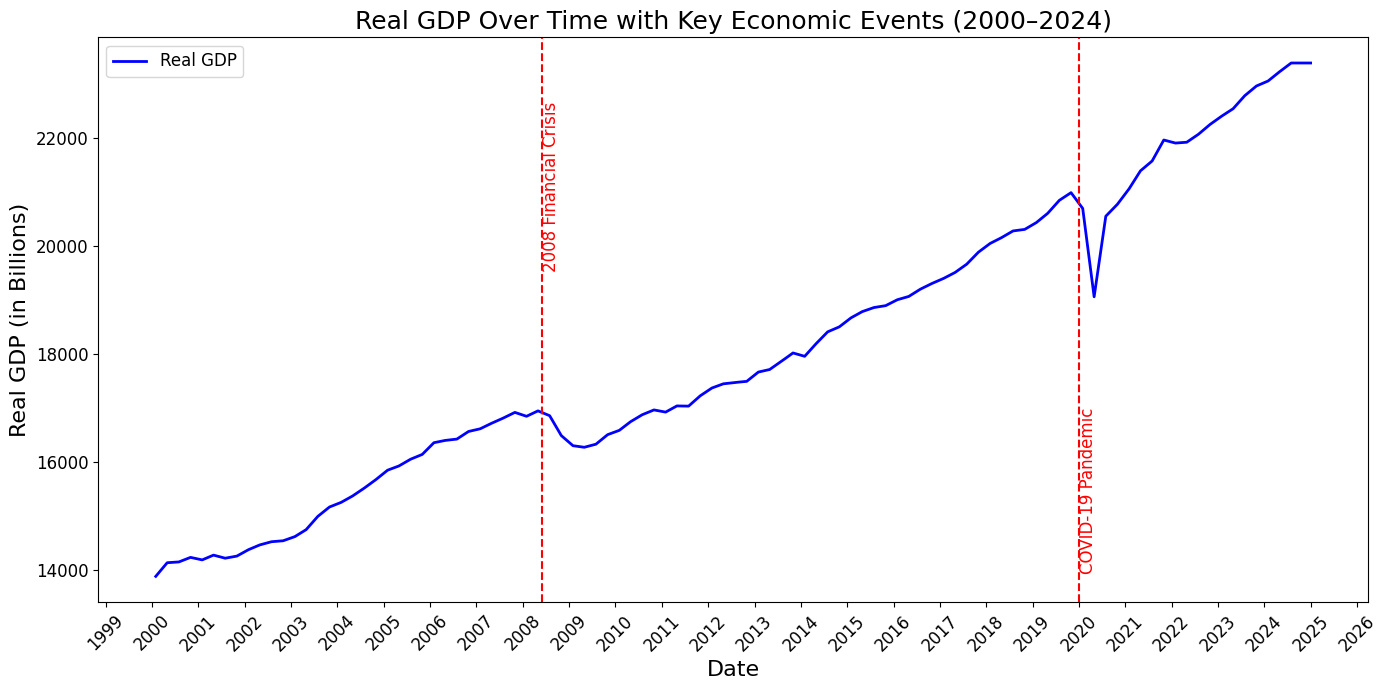

In [3]:
# figure and axis
plt.figure(figsize=(14, 7))

# Ploting Real GDP 
sns.lineplot(x=data.index, y='Real_GDP', data=data, color='blue', linewidth=2, label='Real GDP')

# Highlighting specific events 
events = {
    '2008 Financial Crisis': '2008-06-01',
    'COVID-19 Pandemic': '2020-01-01'
}

for event, date in events.items():
    # Convert date string to datetime
    event_date = pd.to_datetime(date)
    
    # vertical line
    plt.axvline(event_date, color='red', linestyle='--', linewidth=1.5)
    
    # current y-axis limits
    ymin, ymax = plt.ylim()
    
    # vertical alignment and y-position based on the event
    if event == '2008 Financial Crisis':
        va = 'top'
        y_position = ymax * 0.95  # Near the top
    elif event == 'COVID-19 Pandemic':
        va = 'bottom'
        y_position = ymin + (ymax - ymin) * 0.05  # Near the bottom
    else:
        va = 'center'
        y_position = (ymax + ymin) / 2  # Default center position
    
    # text annotation 
    plt.text(event_date, y_position, event, rotation=90, verticalalignment=va, color='red', fontsize=12)

# Adding title and labels
plt.title('Real GDP Over Time with Key Economic Events (2000–2024)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Real GDP (in Billions)', fontsize=16)

# Defining the date format
date_format = mdates.DateFormatter('%Y')

# Setting ticks to every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(date_format)

# Rotating x-axis labels 
plt.xticks(rotation=45, fontsize=12)

# Increasing y-axis label font size
plt.yticks(fontsize=12)

# legend with increased font size
plt.legend(fontsize=12)

# Adjust layout 
plt.tight_layout()

# Show the plot
plt.show()


The plot of U.S. real GDP from 2000 to 2024 reveals a generally upward trend, punctuated by two significant disruptions: the Financial Crisis of 2008-2009 and the COVID-19 pandemic in 2020. From 2000 until mid-2008, real GDP grew steadily, reflecting a robust economic expansion. However, the Financial Crisis caused a sharp contraction in real GDP, with the downturn lasting from mid-2008 to mid-2009. This period marked one of the most severe economic declines in recent history. Following the crisis, the economy rebounded, entering a prolonged phase of growth that persisted until early 2020. The onset of the COVID-19 pandemic then triggered another dramatic fall in real GDP, driven by widespread lockdowns and disruptions to global supply chains. Despite this, the recovery was remarkably swift, supported by aggressive fiscal and monetary policy interventions. Real GDP has since resumed its upward trajectory, demonstrating the resilience of the U.S. economy in the face of significant shocks. 

For the first part of our analysis, we will examine business sector performance during three eras: Era 1, the pre-financial crisis period (2000–2008); Era 2, the financial crisis and recovery period (2008–2020); and Era 3, the COVID pandemic and post-COVID period (2020–2024).

In [4]:
# Defining era date ranges
era1_start = '2000-01-01'
era1_end = '2008-06-01'

era2_start = '2008-06-01'
era2_end = '2020-01-01'

era3_start = '2020-01-01'
era3_end = '2024-12-01'

# Filtering data for each era
era1_data = data.loc[era1_start:era1_end]
era2_data = data.loc[era2_start:era2_end]
era3_data = data.loc[era3_start:era3_end]


In [5]:
# Defining sector columns
sector_columns = [
    'Communication Services', 'Real Estate', 'Materials', 'Energy',
    'Financials', 'Industrials', 'Technology', 'Consumer Staples',
    'Utilities', 'Health Care', 'Consumer Discretionary'
]

# Function to normalize sector data
def normalize_era(era_df, sector_cols):
    return era_df[sector_cols].div(era_df[sector_cols].iloc[0]).mul(100)

# Normalize each era
era1_norm = normalize_era(era1_data, sector_columns)
era2_norm = normalize_era(era2_data, sector_columns)
era3_norm = normalize_era(era3_data, sector_columns)


In [6]:
# Assign a color palette with sufficient distinct colors
palette = sns.color_palette("tab20", len(sector_columns))  

# Creating a dictionary mapping each sector to a color
sector_colors = {sector: palette[i] for i, sector in enumerate(sector_columns)}

# Convert the seaborn palette to hexadecimal colors for Plotly using matplotlib.colors.to_hex
sector_colors_hex = {sector: mcolors.to_hex(color) for sector, color in sector_colors.items()}


In [7]:
# Function to compute log returns
def compute_log_returns(era_norm_df):
    return np.log(era_norm_df / era_norm_df.shift(1)).dropna()

# Compute log returns for each era
era1_returns = compute_log_returns(era1_norm)
era2_returns = compute_log_returns(era2_norm)
era3_returns = compute_log_returns(era3_norm)

# Function to compute average return and risk
def compute_stats(returns_df):
    avg_return = returns_df.mean() * 12  # Annualize the average monthly return
    risk = returns_df.std() * np.sqrt(12)  # Annualize the standard deviation
    return avg_return, risk

# Compute stats for each era
era1_avg_return, era1_risk = compute_stats(era1_returns)
era2_avg_return, era2_risk = compute_stats(era2_returns)
era3_avg_return, era3_risk = compute_stats(era3_returns)


In [8]:
# Function to create stats dataframe
def create_stats_df(avg_return, risk, period_label):
    return pd.DataFrame({
        'Sector': avg_return.index,
        'Period': period_label,
        'Return': avg_return.values,
        'Risk': risk.values
    })

# Create stats dataframes for each era
era1_stats = create_stats_df(era1_avg_return, era1_risk, '2000-2008')
era2_stats = create_stats_df(era2_avg_return, era2_risk, '2008-2020')
era3_stats = create_stats_df(era3_avg_return, era3_risk, '2020-2024')

# Combine all eras into a single DataFrame
full_data = pd.concat([era1_stats, era2_stats, era3_stats], ignore_index=True)


In [9]:
# Defining estimated market caps for each era
market_caps_era1 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2000-2008',
    'Market Cap (Trillion USD)': [
        0.60, 0.60, 0.45, 0.60,
        2.25, 1.80, 1.50, 1.05,
        0.45, 1.80, 2.40
    ]
})

market_caps_era2 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2008-2020',
    'Market Cap (Trillion USD)': [
        3.00, 0.90, 0.60, 0.60,
        3.30, 2.40, 8.10, 1.80,
        0.60, 3.90, 4.80
    ]
})

market_caps_era3 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2020-2024',
    'Market Cap (Trillion USD)': [
        4.40, 0.80, 0.80, 1.20,
        4.00, 2.80, 12.00, 2.00,
        0.80, 5.20, 6.80
    ]
})

# Combining all market cap data
all_market_caps = pd.concat([market_caps_era1, market_caps_era2, market_caps_era3], ignore_index=True)

# Merging the market cap data with full_data
full_data_with_market_cap = pd.merge(
    full_data,
    all_market_caps,
    on=['Sector', 'Period'],
    how='left'
)

# Displaying the combined DataFrame
full_data_with_market_cap.head()


,Sector,Period,Return,Risk,Market Cap (Trillion USD)
0,Communication Services,2000-2008,0.078635,0.191769,0.60
1,Real Estate,2000-2008,0.190385,0.314944,0.60
2,Materials,2000-2008,0.100885,0.188060,0.45
3,Energy,2000-2008,0.152933,0.205274,0.60
4,Financials,2000-2008,0.029219,0.168447,2.25


In [10]:
# Function to calculate maximum drawdown for a pandas Series
def calculate_max_drawdown(series):
    """
    Calculate the maximum drawdown of a time series.

    Parameters:
    series (pd.Series): The time series data.

    Returns:
    float: The maximum drawdown as a positive percentage.
    """
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()  # This will be negative
    return abs(max_drawdown) * 100  # Convert to positive percentage

# Calculate maximum drawdown for each sector in each era
def get_max_drawdowns(era_norm_df, sectors):
    """
    Calculate maximum drawdowns for all sectors in a given era.

    Parameters:
    era_norm_df (pd.DataFrame): Normalized data for the era.
    sectors (list): List of sector column names.

    Returns:
    pd.Series: Maximum drawdown for each sector.
    """
    return era_norm_df[sectors].apply(calculate_max_drawdown)

# Calculate drawdowns for each era
max_drawdown_era1 = get_max_drawdowns(era1_norm, sector_columns)
max_drawdown_era2 = get_max_drawdowns(era2_norm, sector_columns)
max_drawdown_era3 = get_max_drawdowns(era3_norm, sector_columns)

In [11]:
# Function to plot maximum drawdowns interactively using Plotly
def plot_max_drawdown_interactive(max_drawdown_series, era_label, sector_colors_hex):
    """
    Plot an interactive vertical bar chart of maximum drawdowns for a given era using Plotly.

    Parameters:
    max_drawdown_series (pd.Series): Maximum drawdown values for sectors.
    era_label (str): Label for the era (e.g., 'Era 1').
    sector_colors_hex (dict): Mapping of sector names to hex color codes.
    """
    # Sort the drawdowns in descending order
    sorted_drawdown = max_drawdown_series.sort_values(ascending=False)
    
    # Create a DataFrame for Plotly
    df_plot = pd.DataFrame({
        'Sector': sorted_drawdown.index,
        'Maximum Drawdown (%)': sorted_drawdown.values
    })
    
    # Round the Maximum Drawdown (%) to one decimal place
    df_plot['Maximum Drawdown (%)'] = df_plot['Maximum Drawdown (%)'].round(1)
    
    # Create a color mapping for Plotly
    color_map = {sector: sector_colors_hex[sector] for sector in sorted_drawdown.index}
    
    # Create the bar chart with increased height and rounded text
    fig = px.bar(
        df_plot,
        x='Sector',
        y='Maximum Drawdown (%)',
        color='Sector',
        color_discrete_map=color_map,
        title=f'Maximum Drawdown by Sector - {era_label}',
        labels={'Maximum Drawdown (%)': 'Maximum Drawdown (%)', 'Sector': 'Sector'},
        text='Maximum Drawdown (%)',  # Display the drawdown value on bars
        width=1200,
        height=600  # Increase the plot height to 700 pixels
    )
    
    # Update the text to format with one decimal place and a percentage sign
    fig.update_traces(
        texttemplate='%{text:.1f}%',  # Format text labels to one decimal place
        textposition='outside'  # Position text labels outside the bars
    )
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Sector',
        yaxis_title='Maximum Drawdown (%)',
        legend_title='Sector',
        title_x=0.5,  # Center the title
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        plot_bgcolor='rgba(0,0,0,0)',  # Make background transparent
        margin=dict(t=100, l=40, r=40, b=100)  # Adjust margins if necessary
    )
    
    # Format y-axis ticks to show one decimal place
    fig.update_yaxes(
        tickformat=".1f",  # One decimal place
        title_font=dict(size=14),
        tickfont=dict(size=12)
    )
    
    # Optionally, adjust the y-axis to add some padding
    fig.update_yaxes(range=[0, df_plot['Maximum Drawdown (%)'].max() * 1.1])
    
    # Show the figure
    fig.show()


## 3.1 Era 1 (2000-2008) ##

In [13]:
# Creating a line plot for Era 1
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era1_norm.index,
            y=era1_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 1: Jan 2000 - Jun 2008 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()





The analysis of business sector performance between 2000 and 2008 reveals notable disparities among sectors. Real Estate and Energy emerged as the best-performing sectors during this period. The strong performance of Real Estate can be attributed to the formation of the real estate bubble, characterised by surging property prices and speculative investment, fueled by lax lending practices and a booming housing market. Similarly, the Energy sector thrived as the expanding global economy drove increased demand for oil and other energy resources, leading to higher prices and profitability for energy companies. In contrast, the Technology sector faced significant challenges, reflecting the aftermath of the dot-com bubble burst in the early 2000s. This collapse led to a sharp decline in technology stock valuations and a prolonged recovery period, suppressing overall sector performance.

In [15]:
# Filter data for Era 1
era1_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2000-2008'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era1_bubble_data['Risk'] = era1_bubble_data['Risk'] * 100
era1_bubble_data['Return'] = era1_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era1_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2000-2008)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era1_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era1_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era1_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era1_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era1_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era1_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era1_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era1_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era1_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The annualised risk vs. return bubble plot provides valuable insights into sector performance. Sectors such as Utilities and Industrials stand out for offering above-average returns coupled with below-average risk, making them attractive options for investors seeking a favorable risk-return tradeoff. Returns are calculated as the average annual compounded return, reflecting consistent growth over time, while risk is measured by the annualised standard deviation, indicating the volatility of returns. The bubble size in the plot represents the market capitalisation of each sector, highlighting the relative scale of their contribution to the market. Notably, Financials and Consumer Discretionary are the two sectors with the largest market caps, underscoring their significant influence on the broader economy.

In [16]:
# Plotting Maximum Drawdown for Era 1
plot_max_drawdown_interactive(
    max_drawdown_era1, 
    'Era 1 (2000-2008)', 
    sector_colors_hex
)


The maximum drawdown plot reveals that the Technology sector experienced the most severe peak-to-trough decline during the analysed period, reflecting its vulnerability during market downturns. This pronounced drop is primarily attributed to the bursting of the dot-com bubble in the early 2000s, a period characterised by excessive speculation and overvaluation of technology stocks. When the bubble burst, investor confidence in the sector plummeted, leading to sharp declines in stock prices and significant capital losses. This event not only highlights the risks associated with speculative market behavior but also underscores the importance of understanding sector-specific vulnerabilities when evaluating investment opportunities. 

## 3.2 Era 2 (2008-2020) ##

In [17]:
# Creating a line plot for Era 2
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era2_norm.index,
            y=era2_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 2: Jun 2008 - Jan 2020 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()


During Era 2, encompassing the financial crisis and subsequent recovery (2008–2020), the impact of the 2008-2009 financial crisis was evident across all sectors, with sharp declines in performance. The Financials sector experienced the most significant drop, reflecting the systemic instability caused by the collapse of major financial institutions, a credit crunch, and plummeting asset values. However, during the recovery phase, the Communication Services sector emerged as the standout performer, outperforming all other sectors. This strong performance can be attributed to a combination of factors, including historically low borrowing costs, which facilitated capital investment, and the rise of innovative business models in areas like digital media, internet services, and telecommunications. Companies within this sector leveraged technological advancements and shifting consumer behaviors to drive growth, positioning Communication Services as a leader in the post-crisis economic rebound. This era highlights the resilience and adaptability of certain sectors in responding to economic challenges and opportunities.

In [18]:
# Filter data for Era 2
era2_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2008-2020'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era2_bubble_data['Risk'] = era2_bubble_data['Risk'] * 100
era2_bubble_data['Return'] = era2_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era2_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2008-2020)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era2_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era2_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era2_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era2_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era2_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era2_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era2_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era2_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era2_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The risk vs. return bubble plot for Era 2 (2008–2020) highlights a distinct performance contrast among sectors. Technology and Communication Services sectors stand out as the most attractive, offering above-average returns with below-average risk. This favorable risk-return profile reflects their resilience and adaptability during the recovery period, with Technology benefiting from rapid innovation, digital transformation, and increased consumer adoption of technology. Communication Services similarly thrived on innovation and shifting consumer preferences toward digital connectivity and media. Conversely, the Financials and Energy sectors showed the weakest risk-return tradeoff. Financials were severely impacted by the financial crisis, struggling to recover fully due to regulatory overhauls and lingering systemic vulnerabilities. The Energy sector faced a slow recovery, with fluctuating oil prices and global shifts toward renewable energy weighing on performance. Notably, this period also marked Technology’s emergence as the largest sector in the U.S. stock market, underscoring its growing dominance and pivotal role in driving economic growth and investor returns.

In [19]:
# Plotting Maximum Drawdown for Era 2
plot_max_drawdown_interactive(
    max_drawdown_era2, 
    'Era 2 (2008-2020)', 
    sector_colors_hex
)


The max drawdown plot vividly illustrates the widespread impact of the 2008 financial crisis, with significant peak-to-trough declines across all sectors. This underscores the far-reaching and systemic nature of the crisis, which stemmed from the collapse of the housing market and its ripple effects through the financial system. The Financials sector was the hardest hit, experiencing the largest drawdown due to its direct exposure to bad loans, subprime mortgages, and the resulting credit crunch. Other sectors also suffered severe declines, with Energy, Materials, Industrials, and Real Estate experiencing drawdowns of around 50%. These sectors were heavily affected by reduced consumer spending and plummeting investment activity during the crisis. This widespread contraction highlights the interconnectedness of the economy and the cascading effects of financial instability across multiple industries. The financial crisis serves as a stark reminder of the vulnerabilities within the economic system and the profound impact of systemic shocks on market performance.

## 3.3 Era 3 (2020-2024) ##

In [20]:
# Creating a line plot for Era 3
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era3_norm.index,
            y=era3_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 3: Jan 2020 - Dec 2024 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()


During Era 3 (2020–2024), the U.S. stock market experienced significant volatility across all sectors, driven by a series of major global events. The onset of the COVID-19 pandemic caused sharp declines as the world came to a standstill, with the Energy sector being particularly hard hit due to collapsing oil demand. However, an unprecedented rebound followed, fueled by massive government stimulus programs and monetary easing that injected liquidity into the economy and restored investor confidence. The recovery was short-lived, as sectors faced another sharp downturn when central banks, responding to elevated inflation, began hiking interest rates at the fastest pace in history, increasing borrowing costs and pressuring valuations. Subsequently, a new uptrend emerged, led by the Technology sector, which benefited from advancements in Artificial Intelligence and heightened investor interest in transformative innovations. The Energy sector also sustained its post-pandemic rally, driven by geopolitical tensions, including the war in Ukraine, which led to a surge in oil prices. This period underscores the dynamic interplay of global events and sector-specific drivers shaping market performance.

In [21]:
# Filter data for Era 3
era3_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2020-2024'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era3_bubble_data['Risk'] = era3_bubble_data['Risk'] * 100
era3_bubble_data['Return'] = era3_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era3_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2020-2024)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era3_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era3_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era3_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era3_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era3_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era3_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era3_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era3_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era3_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The risk vs. return bubble plot for Era 3 (2020–2024) reveals that the Technology sector offered the most attractive risk-return profile, standing out as a clear leader. This was driven by explosive growth in artificial intelligence (AI) and large language models, which revolutionised various industries. Key contributors to this trend included Nvidia, whose cutting-edge hardware enabled the training of advanced AI models, and the so called "Magnificent 7" – a group of leading tech companies that heavily invested in AI development and integration. These advancements not only propelled the Technology sector’s returns but also reinforced its dominance in the market. As a result, the sector's market capitalization expanded significantly, further increasing its share of the U.S. stock market. This highlights how innovation and the rapid adoption of transformative technologies can redefine sector dynamics and create significant value for investors.

In [22]:
# Plotting Maximum Drawdown for Era 3
plot_max_drawdown_interactive(
    max_drawdown_era3, 
    'Era 3 (2020-2024)', 
    sector_colors_hex
)


The max drawdown plot highlights the Energy sector as the most severely impacted during the pandemic, experiencing the largest peak-to-trough decline. This was primarily driven by the unprecedented collapse in oil prices as the COVID-19 pandemic brought global mobility and economic activity to a halt. Travel restrictions, reduced industrial output, and plummeting demand for transportation fuels led to a historic oversupply of oil, with storage capacities nearing their limits. This situation culminated in negative oil prices for the first time in history, reflecting the extreme market dislocation. The sharp drop underscores the vulnerability of the Energy sector to macroeconomic shocks and demand fluctuations, particularly during crises that disrupt global supply chains and consumer behavior. The pandemic-induced crash served as a stark reminder of the sector’s sensitivity to external shocks and the importance of diversification and adaptability in mitigating such risks.